# 4. Implement a probabilistic model to detect Spam Email with Naive Bayes

# Get dataset (Spam Ham Dataset)


In [1]:
! pip install -q kaggle

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yashpraveshs22","key":"5f8ea32b1b3aad435902a3b249492aac"}'}

In [2]:
# get data from kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download venky73/spam-mails-dataset

  0% 0.00/1.86M [00:00<?, ?B/s]
100% 1.86M/1.86M [00:00<00:00, 178MB/s]


In [3]:
#unzip data
! unzip /content/spam-mails-dataset.zip -d /content/

Archive:  /content/spam-mails-dataset.zip
  inflating: /content/spam_ham_dataset.csv  


In [4]:
import numpy as np
import pandas as pd

emails = pd.read_csv("/content/spam_ham_dataset.csv")
emails

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0
...,...,...,...,...
5166,1518,ham,Subject: put the 10 on the ft\r\nthe transport...,0
5167,404,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0
5168,2933,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0
5169,1409,ham,Subject: industrial worksheets for august 2000...,0


In [5]:
def get_email_subject(email):
    subject = email[0:email.find('\r\n')]
    subject = subject. replace('Subject: ', '')
    return subject

def get_email_body(email):
    body = email[email.find('\r\n')+2:]
    return body

In [6]:
# cleaning of columns
email_df = emails.drop(['Unnamed: 0', "label_num"], axis = 1)

# get the subject and body of email
email_df["subject"] = email_df["text"].apply(lambda x: get_email_subject(x))
email_df["body"] = email_df["text"].apply(lambda x: get_email_body(x))

# ridding of the text column (unless we need it)
email_df = email_df.drop(["text"], axis = 1)

email_df

# expand default pandas display options to make emails more clearly visible when printed
pd.set_option('display.max_colwidth', 200)

# email_df is new our dataframe
email_df.head()

,label,subject,body
0,ham,enron methanol ; meter # : 988291,"this is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary\r\nflow data provided by daren } .\r\nplease override pop ' s daily volume { presently zero } to reflect daily\r\nac..."
1,ham,"hpl nom for january 9 , 2001",( see attached file : hplnol 09 . xls )\r\n- hplnol 09 . xls
2,ham,neon retreat,"ho ho ho , we ' re around to that most wonderful time of the year - - - neon leaders retreat time !\r\ni know that this time of year is extremely hectic , and that it ' s tough to think about anyt..."
3,spam,"photoshop , windows , office . cheap . main trending",abasements darer prudently fortuitous undergone\r\nlighthearted charm orinoco taster\r\nrailroad affluent pornographic cuvier\r\nirvin parkhouse blameworthy chlorophyll\r\nrobed diagrammatic fogar...
4,ham,re : indian springs,"this deal is to book the teco pvr revenue . it is my understanding that teco\r\njust sends us a check , i haven ' t received an answer as to whether there is a\r\npredermined price associated with..."


# Text/Data Pre-processing

In [7]:
# hyperparameters 
maxtokens = 200 # the maximum number of tokens per document
maxtokenlen = 100 # the maximum length of each token

In [8]:
# Tokenization method 1
# this is tokenization split by white space
def tokenize_1(row):
    if row is None or row is '':
        tokens = ""
    else:
        tokens = str(row).split(" ")[:maxtokens]
    return tokens

<>:4: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:4: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-8-c38cb2de81e0>:4: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if row is None or row is '':


In [9]:
from nltk.tokenize import word_tokenize, wordpunct_tokenize

In [10]:
# Tokenization method 2
# split of white space AND punctuation $3.88 --> '3', '.', '88'
def tokenize_2(row):
    return wordpunct_tokenize(str(row))[:maxtokens]

In [11]:
import re
# this covers lower() tokens
def reg_expressions(row):
    row = re.sub(r'[\r\n]', "", row)
    return row

In [12]:
import nltk
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
print(stopwords[:10])

def stop_word_removal(row):
    token = [token for token in row if token not in stopwords]
    return token

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
def stemming(row):
    port_stemmer = nltk.stem.porter.PorterStemmer()
    token = [port_stemmer.stem(token) for token in row]
    return token

In [14]:
def lemmatization(row):
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    token = [lem.lemmatize(token) for token in row]
    return token

In [15]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_tokenize=1,flg_stemm=False, flg_lemm=True, flg_stopwords=True):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = reg_expressions(text)

    ## Tokenize (convert from string to list)
    if flg_tokenize == 1:
        text = tokenize_1(text)

    elif flg_tokenize == 2:
        text = tokenize_2(text)
    
    # remove Stopwords
    if flg_stopwords == True:
        text = stop_word_removal(text)
        
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        text = stemming(text)
        
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        text = lemmatization(text)
            
    ## back to string from list
    text = " ".join(text)
    return text

In [16]:
nltk.download('wordnet')
nltk.download('omw-1.4') #Open Multilingual Wordnet

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [17]:
# Tokenization, Stemming,Lemmatization, Stopwords
email_df["text_clean"] = email_df["body"].apply(lambda x: utils_preprocess_text(x, flg_tokenize=2, flg_stemm=True, flg_lemm=True, flg_stopwords=True))
email_df

,label,subject,body,text_clean
0,ham,enron methanol ; meter # : 988291,"this is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary\r\nflow data provided by daren } .\r\nplease override pop ' s daily volume { presently zero } to reflect daily\r\nac...","follow note gave monday , 4 / 3 / 00 { preliminaryflow data provid daren } . plea overrid pop ' daili volum { present zero } reflect dailyact obtain ga control . chang need asap econom purpos ."
1,ham,"hpl nom for january 9 , 2001",( see attached file : hplnol 09 . xls )\r\n- hplnol 09 . xls,( see attach file : hplnol 09 . xl )- hplnol 09 . xl
2,ham,neon retreat,"ho ho ho , we ' re around to that most wonderful time of the year - - - neon leaders retreat time !\r\ni know that this time of year is extremely hectic , and that it ' s tough to think about anyt...","ho ho ho , ' around wonder time year - - - neon leader retreat time ! know time year extrem hectic , ' tough think anyth past holiday , life go past week decemb 25 januari 1 , ' ' like think minut..."
3,spam,"photoshop , windows , office . cheap . main trending",abasements darer prudently fortuitous undergone\r\nlighthearted charm orinoco taster\r\nrailroad affluent pornographic cuvier\r\nirvin parkhouse blameworthy chlorophyll\r\nrobed diagrammatic fogar...,aba darer prudent fortuit undergonelightheart charm orinoco tasterrailroad affluent pornograph cuvierirvin parkhous blameworthi chlorophyllrob diagrammat fogarti clear baydainconvenienc manag repr...
4,ham,re : indian springs,"this deal is to book the teco pvr revenue . it is my understanding that teco\r\njust sends us a check , i haven ' t received an answer as to whether there is a\r\npredermined price associated with...","deal book teco pvr revenu . understand tecojust send u check , ' receiv answer whether apredermin price associ deal teco let u know whatw give . continu chase deal need ."
...,...,...,...,...
5166,ham,put the 10 on the ft,"the transport volumes decreased from 25000 to 10000 . all 10000 should be on\r\ncontract 012 - 41991 - 203 .\r\nthanks ,\r\nami\r\n- - - - - - - - - - - - - - - - - - - - - - forwarded by ami chok...","transport volum decreas 25000 10000 . 10000 oncontract 012 - 41991 - 203 . thank , ami - - - - - - - - - - - - - - - - - - - - - - forward ami chokshi / corp / enron 08 / 31 / 200010 : 54 - - - - ..."
5167,ham,3 / 4 / 2000 and following noms,"hpl can ' t take the extra 15 mmcf / d over the weekend . we ' ll try next week ,\r\nbut for now the nom will stay at 60 mmcf / d , with redeliveries as they have\r\nbeen\r\n-\r\n50 into pg & e , ...","hpl ' take extra 15 mmcf / weekend . ' tri next week , nom stay 60 mmcf / , redeliveri havebeen - 50 pg & e , 7 fcv , 3 carthag .- - - - - - - - - - - - - - - - - - - - - - forward bruce mcmill / ..."
5168,ham,calpine daily gas nomination,">\r\n>\r\njulie , as i mention earlier we hope to start the unit this afternoon but\r\nare still experiencing difficulties . i will keep you informed . thanks .\r\nricky a . archer\r\nfuel supply\...",">> juli , mention earlier hope start unit afternoon butar still experienc difficulti . keep inform . thank . ricki . archerfuel supply700 louisiana , suit 2700houston , texa 77002713 - 830 - 8659 ..."
5169,ham,industrial worksheets for august 2000 activity,attached are the worksheets for august 2000 activity . there are three\r\ndifferent worksheets { 2 - supply & 1 - market } .\r\nthe market worksheet is preliminary and will continuously be updated...,"attach worksheet august 2000 activ . threediffer worksheet { 2 - suppli & 1 - market } . market worksheet preliminari continu updatedthroughout month . suppli worksheet captur "" buyback relev pric..."


<Axes: xlabel='label', ylabel='count'>

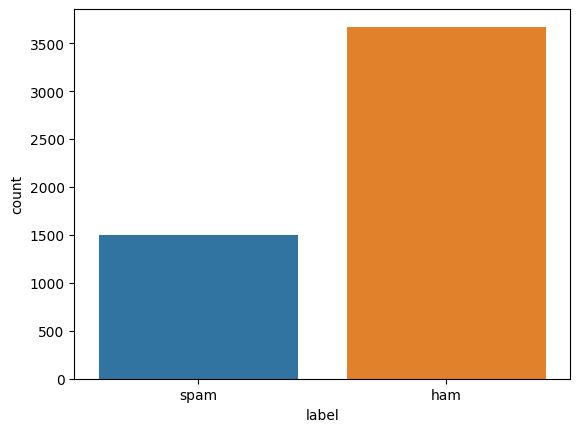

In [18]:
import seaborn as sns
sns.countplot(x="label",data=email_df,order=['spam','ham'])

In [19]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(email_df, test_size=0.20, stratify=email_df["label"], random_state=0)

In [20]:
email_df["label"].value_counts()

ham     3672
spam    1499
Name: label, dtype: int64

In [21]:
email_train_df = train
email_test_df = test

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [23]:
countvectorizer = CountVectorizer(analyzer= 'word', stop_words='english')
tfidfvectorizer = TfidfVectorizer(analyzer='word',stop_words= 'english')

count_wm = countvectorizer.fit_transform(email_train_df["text_clean"])
tfidf_wm = tfidfvectorizer.fit_transform(email_train_df["text_clean"])

count_tokens = countvectorizer.get_feature_names_out()
tfidf_tokens = tfidfvectorizer.get_feature_names_out()


df_countvect = pd.DataFrame(data = count_wm.toarray(),columns = count_tokens)
df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(),columns = tfidf_tokens)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df_countvect, train["label"],test_size= 0.2,random_state=32)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3308, 36203), (828, 36203), (3308,), (828,))

In [25]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB().fit(X_train, y_train)
pred = nb.predict(X_test)

from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test,pred)
print(f'f1 score is: %{acc}')

f1 score is: %0.9396135265700483


In [26]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,pred)
print('here is the confusion matrix: \n',cm)


here is the confusion matrix: 
 [[559  17]
 [ 33 219]]


In [27]:
acc_ham = cm[0][0] /(cm[0][0] + cm[0][1])
print(f'Accuracy of ham class: %{round(acc_ham,2)}')

acc_spam = cm[1][1] /(cm[1][0] + cm[1][1])
print(f'Accuracy of spam class: %{round(acc_spam,2)}')


Accuracy of ham class: %0.97
Accuracy of spam class: %0.87


In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

         ham       0.94      0.97      0.96       576
        spam       0.93      0.87      0.90       252

    accuracy                           0.94       828
   macro avg       0.94      0.92      0.93       828
weighted avg       0.94      0.94      0.94       828

